# <center> Raport firmy GWINTEX S.A.
## <center> Analiza optymalnej liczby zestawów narzędziowych w zależności od kosztów przestoju i kosztów zestawu narzędzi

<br>Zaawansowane Modelowanie Symulacyjne
<br>234060-0723

**Autorzy**
<br>Filip Mordarski, 76671 
<br>Damian Głowacki, 72384 
<br>Mateusz Dalba, 68734
<br>Dorota Szczęsna, 72569

In [1]:
import numpy as np
import random
import scipy as sc
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [4]:
# liczba maszyn
n = 6 

# średni czas pracy bez usterki
avg_working_time = 75 # minut

# średni czas naprawy
avg_repair_time = 15 # minut

# horyzont analizy
horizon = 30 # dni

# liczba uruchomień symulacji
iterations = 10

In [5]:
def model(horizon, avg_working_time, avg_repair_time, n, m, setup, c, cost_inst, m_cost, seed):
    # setup - układ liniowy "L" lub gniazdowy "G"
    
    sc.random.seed(seed)
    
    # horyzont działania w minutach
    horizon = horizon * 24 * 60 
    
    # wektor zdarzeń, który zmienia stan symulacji
    events = list(np.random.exponential(avg_working_time, n))
    
    # status - określa aktualny stan maszyny 
    status = ["W"] * n

    # t_start - określa początek bezczynności maszyny
    t_start = [0] * n

    # t_cum - skumulowany czas bezczynności maszyny
    t_cum = [0] * n

    # tools_loc lokalizacja narzedzi - albo numer maszyny albo -1 czyli warsztat
    tools_loc = [-1] * m

    # tools_occupied czas zajecia zestawu przez naprawianą maszynę
    tools_occupied = [0] * m
    
    # zegar symulacji - najblizsze zadanie, które ma być wykonane
    t = min(events)
    
    #koszt instalacji
    cost_inst = cost_inst if setup=='G' else 0
    
    #koszt narzedzi
    m_costs = m * m_cost
     
    # rozpoczynamy symulacje "skacząc" po kolejnych zdarzeniach  
    while t <= horizon:
        
        # jeżeli zestawy nie są aktualnie zajęte to przenosimy je z powrotem do warsztatu
        for i in range(m):
            if tools_occupied[i] <= t:
                tools_loc[i] = -1

        # wybieramy maszynę, której dotyczy zdarzenie
        machines = []
        for i in range(len(events)):
            if events[i] == t:
                machines.append(i)
        machine = machines[random.randint(0, len(machines)-1)]
        
        """
        Gdy maszyna, której dotyczy zdarzenie ma status "W":
            - to najpierw zaktualizuj wektor t_start dla tej maszyny jako początek jej bezczynności = t.
            - następnie sprawdź czy dostępny jest jakiś zestaw naprawczy. Jezeli nie:
                - to ustaw status maszyny na "Q" 
                - zaktualizuj wektor events podajac mu najkrótszy czas oczekiwania na wolny zestaw.
              Jeżeli tak:
                - ustaw status maszyny na "R"
                - wyznacz czas  potrzebny na naprawę maszyny w zależności od ukladu taśmociągu 
                (czas transportu + czas naprawy)
                - ustaw koniec naprawy jako zdarzenie dla danej maszyny
                - zaktualizuj wektor tools_loc dla odpowiedniego zestawu podając numer maszyny, którą on obsługuje
                - zaktualizuj wektor tools_occupied czasem jaki mu to zajmie (2* transport + naprawa)
        """
        if status[machine] == "W":
            t_start[machine] = t
            tools = - 1
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            if tools == -1 :
                status[machine] = "Q"
                events[machine] = min(tools_occupied)
            else:
                status[machine] = "R"
                if setup == "L":
                    transport_time = 2 * (1 + machine)
                elif setup == "G":
                    transport_time =  3
                else:
                    print("Niepoprawny układ! Należy wybrać układ 'L' lub 'G'!")
                    break
                repair_time = np.random.gamma(3, avg_repair_time/3)
                events[machine] += repair_time + transport_time
                tools_loc[tools] = machine
                tools_occupied[tools] = max(t, tools_occupied[tools]) + repair_time + 2 * transport_time
                
                """
                Gdy maszyna ma status "Q":
                    - wybierz dostępny zestaw naprawczy
                    - ustal status maszyny na "R"
                    - zaktualizuj wektor tools_loc lokalizacją narzedzi i tools_occupied 
                    czasem jaki zajmie ich transport (w dwie strony) i naprawa maszyny
                    -zaktualizuj wektor zdarzeń czasem potrzebnym na naprawę maszyny i transport narzedzi
                """
                
        elif status[machine] == "Q":
            tools = - 1
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            if tools == -1 :
                status[machine] = "Q"
                events[machine] = min(tools_occupied)
            else:
                status[machine] = "R"
                if setup == "L":
                    transport_time = 2 * (1 + machine)
                elif setup == "G":
                    transport_time =  3
                else:
                    print("zly uklad - moze byc L lub G!")
                    break
                repair_time = np.random.gamma(3, avg_repair_time/3)
                events[machine] += repair_time + transport_time
                tools_loc[tools] = machine
                tools_occupied[tools] = max(t, tools_occupied[tools]) + repair_time + 2 * transport_time 
            """
            Gdy maszyna ma status "R":
                - ustal jej status na "W"
                - wyznacz czas kolejnej awarii i zaktualizuj wektor events
                - wylicz czas bezczynnosci i uzupelnij o niego liste t_cum
            """
            
        else:
            status[machine] = "W"
            events[machine] += np.random.exponential(avg_working_time)
            t_cum[machine] += t - t_start[machine]
        
        # ustalamy nowe t
        t = min(events)
        
    t_cost = [t*c for t in t_cum]
    cost = cost_inst + sum(t_cost) + m_costs
    # wynik skumulowany czas oraz koszt
    return (t_cum, cost)

In [6]:
def run_model (iterations, horizon, avg_working_time, avg_repair_time, n, m, setup, c, cost_inst, m_cost):
    avg_t_cum = []
    avg_t_cost = []
    for i in range (iterations):
        x = model(horizon, avg_working_time, avg_repair_time, n, m, setup, c, cost_inst, m_cost, i)
        avg_t_cum.append(x[0])
        avg_t_cost.append(x[1])
    return (list(map(np.mean, np.transpose(avg_t_cum))), np.mean(avg_t_cost))


## 5. Wyniki analizy

<br> W tej części raportu zostaną przedstawione wyniki analizy, które mają na celu wskazać optymalną liczbę zestawów narzędzi w zależności od kosztów przestoju i kosztów zestawu narzędzi. Jak zostało powyżej wspomniane, przedsiębiorstwo ma dwie możliwości rozmieszczenia urządzeń na hali produkcyjnej, w układzie liniowym lub gniazdowym. Z tego względu poniższa analiza będzie uwzględniała również te obie możliwości rozmieszczenia. W poszukiwaniu optymalnej liczby zestawu narzędzi, przyjmiemy że koszt instalacji układu gniazdowego jest stały i wynosi 20,000 jednostek. Koszt za jedną jednostkę czasu przestoju będzie badany z zakresu wartości <3;6>, natomiast koszt jednego zestawu narzędzi z przedziału <5000;50000> z granulacją co 1000. Z opisu problemu wynika, że liczba zestawów narzędzi powinna być niższa niż liczba maszyn. Z tego względu analizowana będzie liczba zestawów narzędzi z przedziału <1;5>.

In [7]:
unit_costs = range(3, 7)
tools_costs = range(5000, 51000, 1000)
tools = range(1, 6)
results = {}
cost_inst = 20000
data = pd.DataFrame()

for m in tools:
    for c in unit_costs:
        for m_cost in tools_costs:
            results[(m, c, m_cost, "G")] = run_model(iterations, horizon, avg_working_time, avg_repair_time, 
                                             n, m, "G", c, cost_inst, m_cost)[1]
            results[(m, c, m_cost, "L")] = run_model(iterations, horizon, avg_working_time, avg_repair_time, 
                                             n, m, "L", c, cost_inst, m_cost)[1]
            data = data.append({"Liczba narzedzi": m, "Koszt jedn.": c, "Koszt zestawu": m_cost, "Ustawienie": "G",
                            "Calkowity koszt": results[(m, c, m_cost, "G")]}, ignore_index=True)
            data = data.append({"Liczba narzedzi": m, "Koszt jedn.": c, "Koszt zestawu": m_cost, "Ustawienie": "L",
                            "Calkowity koszt": results[(m, c, m_cost, "L")]}, ignore_index=True)

W pierwszej kolejności zostanie przeanalizowana optymalna liczba narzędzi w układzie liniowym.

In [8]:
dfs = {i: data[(data['Ustawienie']=='L') & (data['Koszt jedn.']==i)].reset_index().\
       pivot("Liczba narzedzi", "Koszt zestawu", "Calkowity koszt") for i in range(3, 7)}

Text(0.1, -0.01, 'Rysunek 1. Całkowity koszt przedsiębiorstwa dla układu liniowego w zależności od \nliczby zestawów narzędzi, kosztu jednostkowego przestoju oraz kosztu zestawu narzędzi.\nGdy koszt zestawu narzędzi przymuje wartości z przedziału około 5000 - 20000,\n optymalna liczba narzędzi wynosi 4')

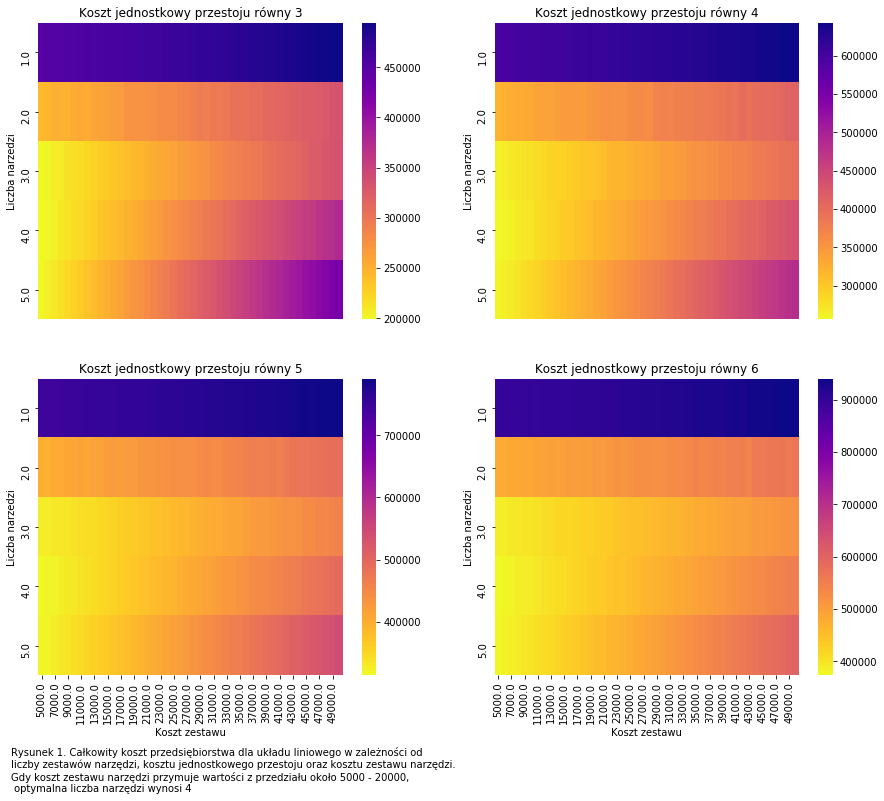

In [9]:
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(dfs[i+3], cmap=cm.plasma_r, ax=ax)
    ax.set_title(f"Koszt jednostkowy przestoju równy {i+3}")
    if i < 2:
        ax.get_xaxis().set_visible(False)
fig2.text(.1, -0.01, "Rysunek 1. Całkowity koszt przedsiębiorstwa dla układu liniowego w zależności od \n"
                     "liczby zestawów narzędzi, kosztu jednostkowego przestoju oraz kosztu zestawu narzędzi.\n"
                     "Gdy koszt zestawu narzędzi przymuje wartości z przedziału około 5000 - 20000,\n " 
                     "optymalna liczba narzędzi wynosi 4", ha='left')        


Na podstawie powyższych wykresów, można wysnuć wniosek że optymalna liczba zestawów narzędzi dla układu liniowego nie zależy od poziomu kosztu jednostkowego przestoju. Wykresy, wygenerowane dla różnych wartości kosztu jednostkowego przestoju, różnią się oczywiście wartościami całkowitego kosztu, ale przebieg relatywnych zmian jest podobny. Można to zaobserwować po zmianach natężenia barw. Liczba zestawu narzędzi różni się natomiast w zależności od kosztu pojedynczego zestawu narzędzi. Gdy koszt zestawu narzędzi oscyluje w okolicach od 5000 do 20000, optymalna liczba narzędzi wynosi 4 we wszystkich przypadkach jednostkowego kosztu przestoju. Natomiast gdy koszt zestawu przekracza 20000, optymalna liczba narzedzi wynosi 3. Przeanalizujmy jak wygląda dokładny przebieg optymalnego rozwiązania dla układu liniowego oraz różnych kosztów przestoju maszyny.

Text(0.01, 0.001, 'Rysunek 2. Optymalna liczba narzędzi w zależności od kosztu zestawu oraz kosztu jednostkowego \nw układzie liniowym. Optymalna liczba narzędzi znajduje się w zakresie <2;4>, zazwyczaj gdy \nkoszt przestoju jest niższy optymalna liczba narzędzi jest mniejsza.')

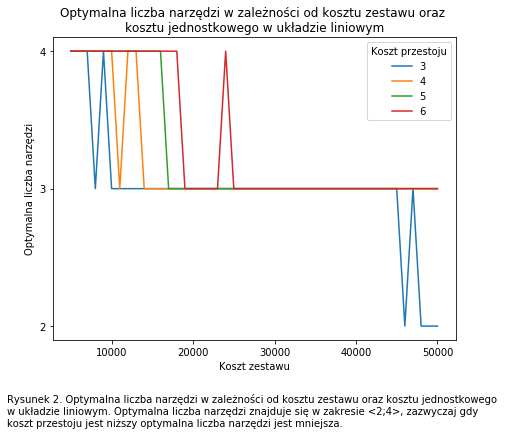

In [10]:
dfs_grouped = {}
for i in range(3, 7):
    df = data[(data['Ustawienie']=='L') & (data['Koszt jedn.']==i)]
    grouped = df.groupby(['Koszt zestawu'])['Calkowity koszt'].min().reset_index()
    final = grouped.merge(df[['Calkowity koszt', "Liczba narzedzi"]], 
                          on='Calkowity koszt', how='left')
    dfs_grouped[i] = final
fig1 = plt.figure(figsize=(7, 6))
ax1 = fig1.add_axes((0.1, 0.2, 0.8, 0.7))
for i in range(3, 7):
    ax1.plot(dfs_grouped[i]['Koszt zestawu'], dfs_grouped[i]['Liczba narzedzi'], label=i)
ax1.legend(loc=1, title='Koszt przestoju')
plt.ylabel('Optymalna liczba narzędzi')
plt.xlabel('Koszt zestawu')
plt.title('Optymalna liczba narzędzi w zależności od kosztu zestawu oraz \n'
          'kosztu jednostkowego w układzie liniowym')
plt.yticks([2, 3, 4])
fig1.text(.01, .001, 
          "Rysunek 2. Optymalna liczba narzędzi w zależności od kosztu zestawu oraz kosztu jednostkowego \n"
          "w układzie liniowym. Optymalna liczba narzędzi znajduje się w zakresie <2;4>, zazwyczaj gdy \n"
          "koszt przestoju jest niższy optymalna liczba narzędzi jest mniejsza.")

Na podstawie powyższego wykresu, można zauważyć, że dla mniejszych wartości jednostkowego kosztu przestoju, optymalna liczba narzędzi jest niższa. Przykładowo, dla kosztu jednostkowego równego 3, optymalna liczba narzędzi spada z 4 do 3 gdy koszt zestawu jest niższy niż 10000. Natomiast, gdy koszt jednostkowego przestoju wynosi 6, optymalna liczba narzędzi spada do 3, gdy koszt zestawu wynosi około 20000. Generalnie, najczęściej występującym rozwiązaniem optymalnem jest wartość 3. Taka liczba zestawów narzędzi jest rekomendowana dla przedsiębiorstwa, gdy maszyny są ustawione w układzie liniowym. Analogicznie zostanie przeprowadzona analiza dla układu gniazdowego.

Text(0.1, -0.01, 'Rysunek 3. Całkowity koszt przedsiębiorstwa dla układu gniazdowego w zależności od \nliczby zestawów narzędzi, kosztu jednostkowego przestoju oraz kosztu zestawu narzędzi.\nGdy koszt zestawu narzędzi przymuje wartości z przedziału około 5000 - 20000,\n optymalna liczba narzędzi najczęściej wynosi 3')

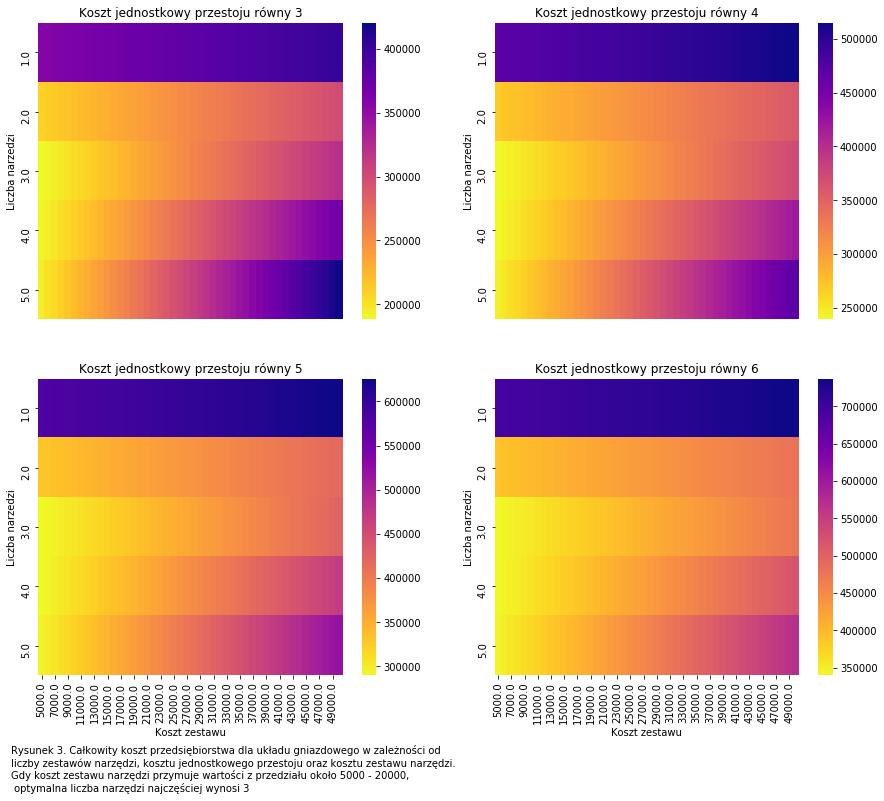

In [11]:
dfs_g = {i: data[(data['Ustawienie']=='G') & (data['Koszt jedn.']==i)].reset_index().\
       pivot("Liczba narzedzi", "Koszt zestawu", "Calkowity koszt") for i in range(3, 7)}
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(dfs_g[i+3], cmap=cm.plasma_r, ax=ax)
    ax.set_title(f"Koszt jednostkowy przestoju równy {i+3}")
    if i < 2:
        ax.get_xaxis().set_visible(False)
fig2.text(.1, -0.01, "Rysunek 3. Całkowity koszt przedsiębiorstwa dla układu gniazdowego w zależności od \n"
                     "liczby zestawów narzędzi, kosztu jednostkowego przestoju oraz kosztu zestawu narzędzi.\n"
                     "Gdy koszt zestawu narzędzi przymuje wartości z przedziału około 5000 - 20000,\n " 
                     "optymalna liczba narzędzi najczęściej wynosi 3", ha='left')        

Na podstawie powyższych wykresów, można wysnuć wniosek, że w układzie gniazdowym mamy do czynienia z podobną sytuacją jak w układzie liniowym. Przebieg zmiany natężenia barw w powyższych 'heatmapach' sugeruje, że optymalna liczba urządzeń zmienia się w podobny sposób dla różnych kosztów jednostkowego przestoju. Warto zauważyć, że wartości na skali barw są mniejsze dla każdego z przedstawionych wykresów. Może to sugerować, że układ gniazdowy jest optymalniejszym rozstawieniem niż układ liniowy. Zostaną przeanalizowane dokładne rozwiązanie optymalne w zależności od kosztu przestoju oraz kosztu zestawu narzędzi dla układu gniazdowego.

Text(0.01, 0.001, 'Rysunek 4. Optymalna liczba narzędzi w zależności od kosztu zestawu oraz kosztu jednostkowego \nw układzie gniazdowym. Optymalna liczba narzędzi znajduje się w zakresie <2;4>, zazwyczaj gdy \nkoszt przestoju jest niższy optymalna liczba narzędzi jest mniejsza.')

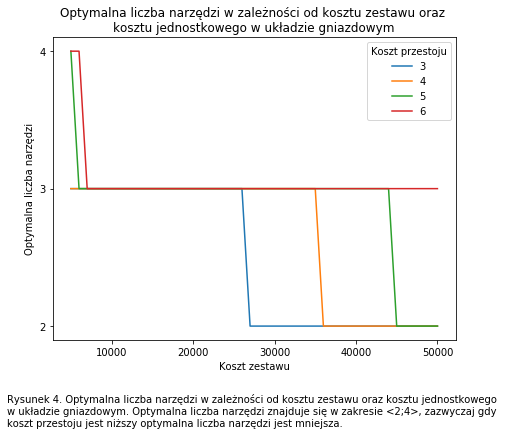

In [12]:
dfs_grouped = {}
for i in range(3, 7):
    df = data[(data['Ustawienie']=='G') & (data['Koszt jedn.']==i)]
    grouped = df.groupby(['Koszt zestawu'])['Calkowity koszt'].min().reset_index()
    final = grouped.merge(df[['Calkowity koszt', "Liczba narzedzi"]], 
                          on='Calkowity koszt', how='left')
    dfs_grouped[i] = final
fig1 = plt.figure(figsize=(7, 6))
ax1 = fig1.add_axes((0.1, 0.2, 0.8, 0.7))
for i in range(3, 7):
    ax1.plot(dfs_grouped[i]['Koszt zestawu'], dfs_grouped[i]['Liczba narzedzi'], label=i)
ax1.legend(loc=1, title='Koszt przestoju')
plt.ylabel('Optymalna liczba narzędzi')
plt.xlabel('Koszt zestawu')
plt.title('Optymalna liczba narzędzi w zależności od kosztu zestawu oraz \n'
          'kosztu jednostkowego w układzie gniazdowym')
plt.yticks([2, 3, 4])
fig1.text(.01, .001, 
          "Rysunek 4. Optymalna liczba narzędzi w zależności od kosztu zestawu oraz kosztu jednostkowego \n"
          "w układzie gniazdowym. Optymalna liczba narzędzi znajduje się w zakresie <2;4>, zazwyczaj gdy \n"
          "koszt przestoju jest niższy optymalna liczba narzędzi jest mniejsza.")

Z powyższego wykresu wynika, że najczęstsza optymalna liczba narzędzi to 3. Co ciekawe, podobnie często występującym rozwiązaniem optymalnym była liczba 2. Powyższy wykres dla układu gniazdowego również sugeruje, że wraz z większym kosztem przestoju maszyny optymalna liczba narzędzi jest wyższa dla danego kosztu zestawu. W celu pogłębionej analizy problemu optymalnej liczby narzędzi została podjęta próba utworzenia drzewa decyzyjnego.  

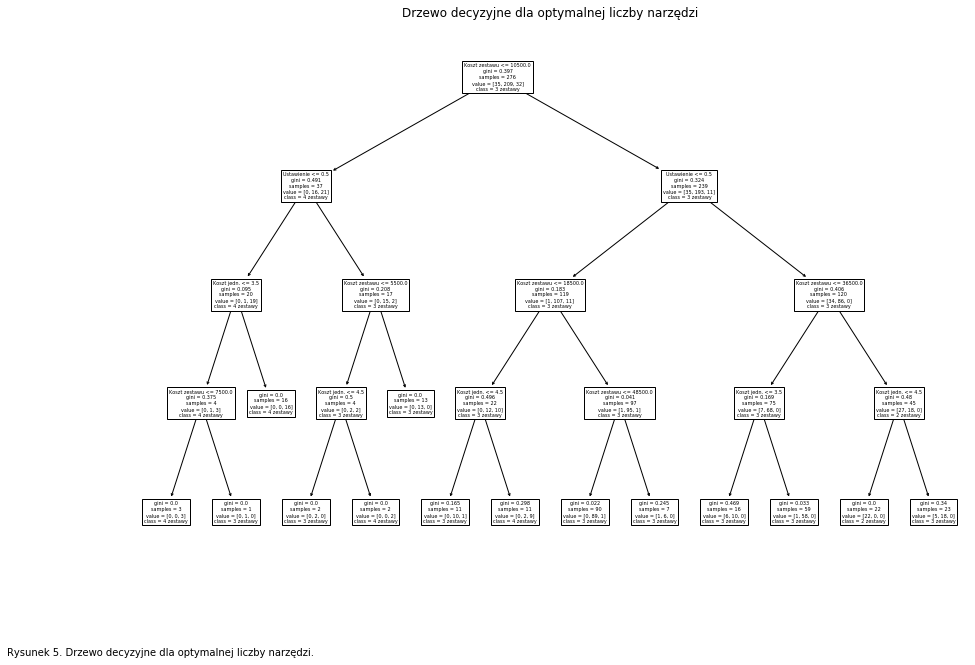

In [14]:
grouped = data.groupby(["Ustawienie", 'Koszt zestawu', "Koszt jedn."])['Calkowity koszt'].min().reset_index()
grouped = grouped.merge(data[['Calkowity koszt', "Liczba narzedzi"]], 
                          on='Calkowity koszt', how='left')
d = {'L': 0, 'G': 1}
grouped['Ustawienie'] = grouped['Ustawienie'].map(d)
features = ["Ustawienie", 'Koszt zestawu', "Koszt jedn."]
# X = grouped[features]
# y = grouped["Liczba narzedzi"]
X_train, X_test, Y_train, Y_test = train_test_split(grouped[features], grouped["Liczba narzedzi"], random_state=0)
dtree = DecisionTreeClassifier(max_depth=4, random_state=0)
dtree = dtree.fit(X_train, Y_train)
score = dtree.score(X_test, Y_test)
fig1 = plt.figure(figsize=(15, 10))
tree.plot_tree(dtree, feature_names=features,
              class_names=['2 zestawy', '3 zestawy', '4 zestawy'])
plt.title('Drzewo decyzyjne dla optymalnej liczby narzędzi')
fig1.text(.01, .001, 
          "Rysunek 5. Drzewo decyzyjne dla optymalnej liczby narzędzi.")
fig1.savefig('tree.png')

W pierwszej kolejności zestaw danych został podzielony na zbiór uczący (75 % pierwotnego zbioru) oraz testowy (25 % pierwotnego zbioru). Następnie został utworzony model drzewa decyzyjnego z maksymalną głebokością korzeni równą 4, aby model nie został zbyt przeuczony. Na powyższym wykresie jest zwizualizowane drzewo decyzyjyne. Nie jest ono zbyt czytelne w jupyter notebooku, więc zostało zapisane do oddzielnego pliku. Takie drzewo decyzyjne będzie pomocne dla przedsiębiorstwa w kwestii podjęcia dezycji odnośnie optymalnej liczby narzędzi. Zostanie przedstawiona jedna wybrana reguła z powyższego drzewa: jeżeli koszt zestawu jest z przedziału (11500;18500> oraz jednostkowy koszt przestoju jest większy niż 4.5 w układzie liniowym, to przedsiębiorstwo powinno kupić 4 zestawy narzędzi.